## The Graph Colouring Problem
By Resul Teymuroglu (rt793@bath.ac.uk) and Oliver McEvoy (om518@bath.ac.uk)

Let's import the modules we need first.

In [1]:
from openqaoa.problems import QUBO
from openqaoa import QAOA
from openqaoa.utilities import ground_state_hamiltonian
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import IBMQ

Consider a graph of $N$ vertices and a set of $k$ colours. The aim of the challenge, at which this notebook has an attempt, is to find a colour for each vertex, such that no two vertices of the same colour are connected by an edge.

Here, we will encode the problem as a cost function, $f(\vec{x})$. We're also working with quantum computers, where the only measured values will be $\uparrow$ and $\downarrow$. Therefore, $\vec{x}$ can be a linear combination of only $\pm 1$s, as in,

$\vec{x} = (x_{1}, \ldots, x_{n}) | x_{i} \in \{-1, +1\}.$

With $\vec{x}$, one cost function we can use is

$f(\vec{x}) = A \displaystyle\sum^{N}_{v} (1-\displaystyle\sum^{k}_{i=1}x_{v,i})^{2} + A \displaystyle\sum _{(uv)\in E} \displaystyle\sum ^{k}_{i=1} x_{u,i}x_{v,i}$,

which can, and should, be converted into a Quadratic Unconstrained Binary Optimisation (QUBO) problem, like so:

$f(\vec{x}) = \displaystyle\sum ^{n}_{i} \displaystyle\sum ^{n}_{j} Q_{ij}x_{i}x_{j}$,

where $Q_{ij}$ is the $n\times n$ matrix encoding the problem.

Since the derivation to the following is relatively lengthy, I will not include it here, but

$Q_{ij} = \begin{cases} -A & i=j, u=v \\ A & i=j, u\ne v \\ A & i\ne j, u=v \\ 0 & i \ne j, u \ne v \end{cases}$.

Since we are working with quantum computers, usage of the Ising encoding, where the binary encoding is $\{ -1,+1 \}$ and not $\{ 0,1 \}$, is required. Now, the cost function becomes

$f(\vec{s}) = \displaystyle\sum _{\langle i j \rangle} J_{ij} s_{i}s_{j} + \displaystyle\sum ^{n}_{i} h_{i}s_{i}$,

where $\vec{s} = \{s_{1}, \ldots, s_{n}\} | s_{i} = \{-1,+1\}, h$ is a vector, and $J$ is a symmetric matrix.

We can work out the values for $J, \vec{h}$ since they're related to $Q$ by,

$J_{ij} = \frac{1}{4}Q_{ij}$,

$J_{ii} = 0$, and

$h_{i} = -\frac{1}{2}Q_{ii} - \frac{1}{4}\displaystyle\sum ^{n}_{j=0, j\ne i}Q_{ij}$.

From here, the rest is just Python...

In [2]:
def graph_coloring_qubo(G, k, A=10) -> QUBO:
    q = lambda u, i: u*k + i
    
    no_of_nodes = k*G.number_of_nodes()    
    new_edges = [(q(u, i), q(v, i)) for u, v in G.edges for i in range(k)]
    
    #initialising and creating Q
    matrix_Q = np.zeros((no_of_nodes, no_of_nodes))
    for u, v in G.edges():
        for i in range(k): #if i=j and u != v            
            matrix_Q[q(u, i), q(v, i)] += A
            matrix_Q[q(v, i), q(u, i)] += A
        
        
    for u in G.nodes(): #if i!=j and u=v
        for i, ii in nx.generators.complete_graph(n=k).edges():
            matrix_Q[q(u, i), q(u, ii)] += A
            matrix_Q[q(u, ii), q(u, i)] += A
    
    
    for u in G.nodes(): #if i=j and u=v
        for i in range(k):
            matrix_Q[q(u, i), q(u, i)] -= A 
    
    
    #transforming Q -> J and setting up h-vector    
    matrix_J = np.where(np.eye(no_of_nodes, dtype=bool) == True, 0, 0.25*matrix_Q)
    
    vector_h = [-0.5 * matrix_Q[i][i] - \
                0.25*sum([matrix_Q[i][j] if i!=j else 0 for j in range(no_of_nodes)]) \
                for i in range(no_of_nodes)]
    
    
    terms, weights = [], []
    
    #let's deal with the vectors first
    for i in range(no_of_nodes):
        terms.append([i])
        weights.append(vector_h[i])
    
        #and now for J
        for j in range(i+1, no_of_nodes):
            if matrix_J[i, j] != 0:
                terms.append([i, j])
                weights.append(matrix_J[i, j])

    
    # print(help(QUBO))
    return QUBO(n=no_of_nodes, terms=terms, weights=weights)

## Testing our Results

So we've written a function that return a QUBO, but what do our results look like?

If we consider a 4-node graph with 3 colours, prior to colouring the graph, we'll get something like this:

In [3]:
k = 3
N = 4

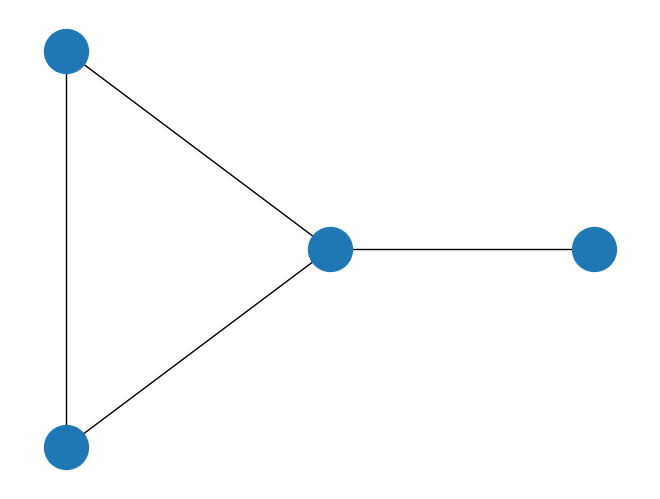

In [4]:
g = nx.Graph()
g.add_edge(0, 1)
g.add_edge(0, 2)
g.add_edge(1, 2)
g.add_edge(2, 3)
nx.draw(g, {0: (0, 0), 1: (0, 2), 2: (1, 1), 3: (2, 1)}, node_size=1000)
plt.show()

So let's colour it in, but first, we'll add a few functions that'll make reading our solutions easier in the long term:

In [5]:
def generate_bitstrings(n):
    bitstrings = []
    for i in range(2**n):
        bitstrings.append(bin(i)[2:].zfill(n))
        
    return bitstrings


def binary_to_knary(bitstr, k):
    assert len(bitstr) % k == 0, "len(bitstr) must be a multiple of k"
    n = len(bitstr) // k

    binary_colors = dict(zip(['0'*(k-i-1) + '1' + '0'*i for i in range(k)], range(k)))
    binary_colors = {bitstr: 'x' if not bitstr in binary_colors else binary_colors[bitstr] for bitstr in generate_bitstrings(k)}

    return ''.join([str(binary_colors[bitstr[i*k:(i+1)*k]]) for i in range(n)])
    
    

And now for the actual colouring:

In [6]:
def colour_qubo_graph(graph, k):
    color_map = {   
        '0': 'blue', 
        '1': 'red',
        '2': 'green',
        '3': 'orange',
        '4': 'purple',
        '5': 'brown',
        '6': 'pink',
        '7': 'gray',
        '8': 'olive',
        '9': 'cyan',
        'x': 'black'
    }
    
    gc_qubo = graph_coloring_qubo(graph, k)
    
    cl_energy, cl_solutions_bitstrings = ground_state_hamiltonian(gc_qubo.hamiltonian)
    print(f'Classical energy: {cl_energy}')
    print(f'Classical solutions: {cl_solutions_bitstrings}')
    
    q = QAOA()    
    q.compile(gc_qubo)
    q.optimize()
    q.result.optimized    
    
    solutions_bitstrings, energy = q.result.most_probable_states.values()
    solutions = [binary_to_knary(bitstr, k) for bitstr in solutions_bitstrings]
    print(f'Quantum Energy: {energy}')
    print(f'Quantum Solutions: {solutions}')

    for i, each in enumerate(solutions):
        node_colors = {node: color_map[color] for node, color in zip(set(g.nodes()), each)}

        nx.draw(g, node_color=[node_colors[node] for node in g.nodes()])
        plt.show()
        
        if i == 2: break #just show 2 graphs

So what do our results look like if $k, N = 2, 4$?

Classical energy: -20.0
Classical solutions: ['01100010', '10010010', '10000110', '00100110', '10100110', '01100110', '10010110', '01100001', '10010001', '01001001', '01101001', '00011001', '10011001', '01011001', '01100011', '10010011']
Quantum Energy: 0.0
Quantum Solutions: ['01x1', '10x1', '01x0', '10x0']


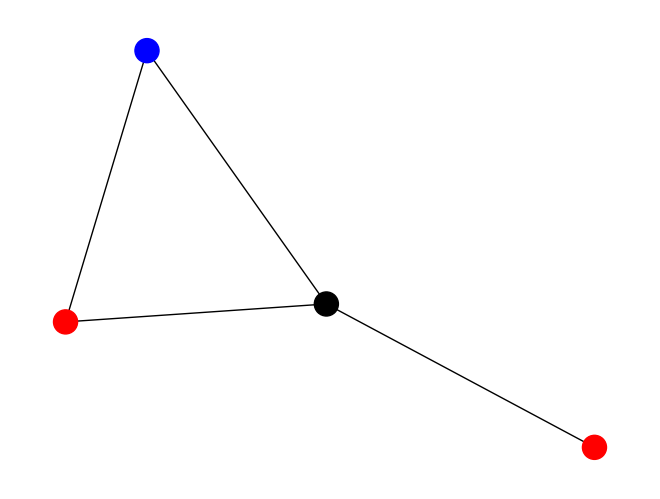

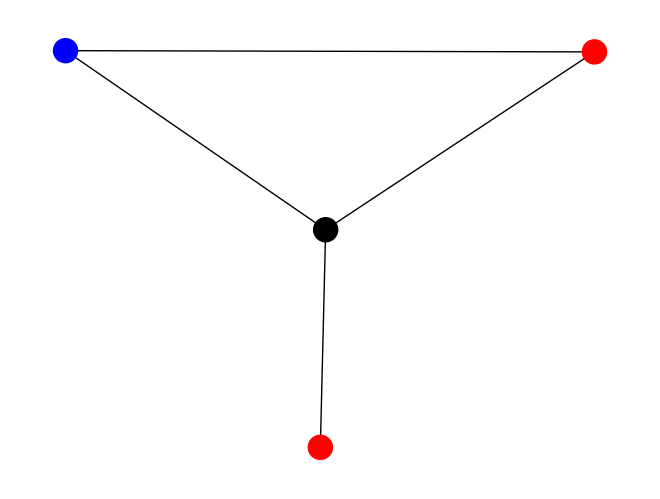

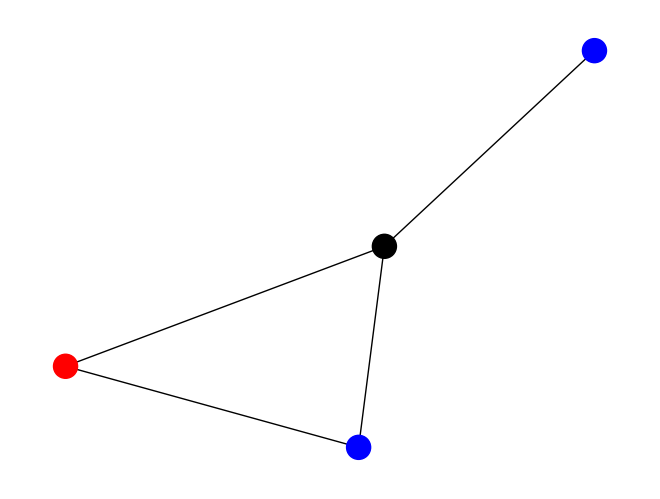

In [7]:
colour_qubo_graph(g, k=2)

These are valid solutions, because no two connected colours are identical.

Therefore, we have successfully coloured our graph for $k, N = 2, 4$.

What about other values? Well, if $N = 6$, then:

Classical energy: -105.0
Classical solutions: ['001010100001010100', '010001100010001100', '001100010001100010', '100001010100001010', '010100001010100001', '100010001100010001']
Quantum Energy: -105.0
Quantum Solutions: ['012012', '102102', '021021', '201201', '120120', '210210']


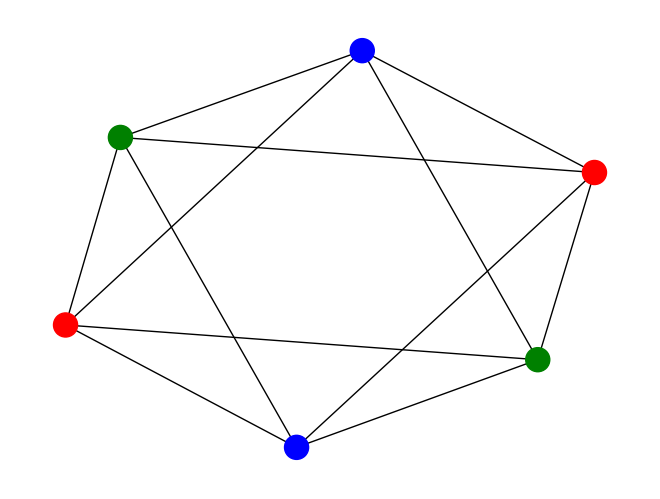

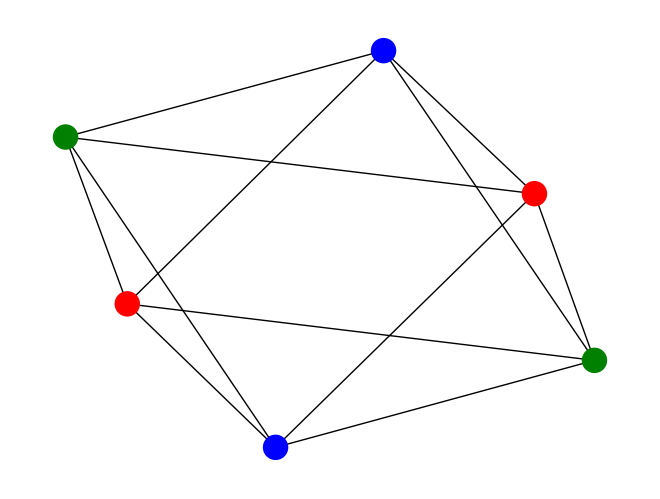

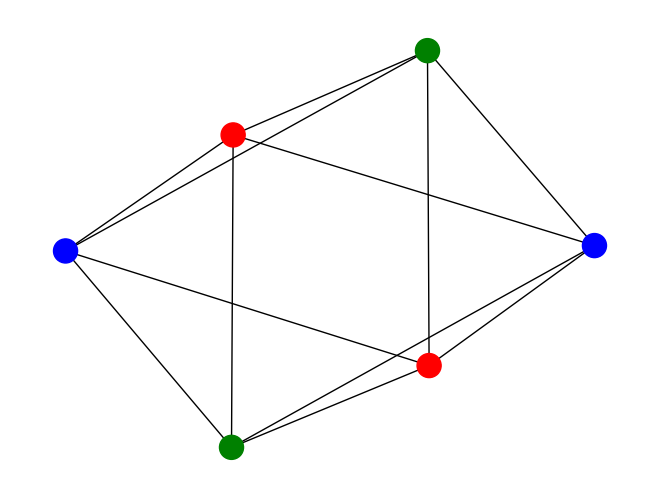

In [8]:
g = nx.Graph()
g.add_edges_from([
                    (0,1), (0,2), (0,4), (0,5), 
                    (1,2), (1,3), (1,5),
                    (2,3), (2,4), 
                    (3,4), (3,5),
                    (4,5) 
                ])

colour_qubo_graph(g, k=3)

What about $N = 7$?

In [ ]:
g = nx.Graph()
g.add_edges_from([
                    (0,1), (0,2), (0,3), (0,4), (0,5), (0,6),
                    (1,2), (2,3), (3,4), (4,5), (5,6), (6,1)
                ])
colour_qubo_graph(g, k=3)

Classical energy: -107.5
Classical solutions: ['001010100010100010100', '010001100001100001100', '001100010100010100010', '100001010001010001010', '010100001100001100001', '100010001010001010001']
